# Summary

Rob Paral and Associates have collected census and community survey data from the US census bureau and summarized it at the Chicago community area level. He / his group did a great job locating and preparing this data and we will pull it in for the analysis at hand. We aren't the first to leverage this data (see http://www.chicagohealthatlas.org/).

The because the data is sourced from a combination of the decennial census data and the more recent 5 year community surveys, we will have to do a bit of work to get this into a monthly timeseries. We will also need to do a bit of modelling. The major decisions are below.

1. Interpolate between known points. For example, we will interpolate fields between the 2000 and 2010 census data to approximate the intermediate time points. The downstream analysis is focused on major movements, and the details of one month to another are not particularly important.
2. Extraplolate beyond the last community survey. Our data ends at 2015. To get more coincident data we have to somehow pull this data forward. Because the timeframe is short between then and now, we just drag the last point forward. It's dragged to the following year to ensure joins on downstream crime timeseries.
3. Conversion of time range (community survey data) to point estimates. Community surveys were conducted over the course of 5 years, we need to associate these with a point in time. This is a bit nubbier and will be broken out separately below.

The raw data is located at the link below, but note that I did a bit of google sheets magic to put it into a formatted table for the cleaning here, a step that is not show.
http://www.robparal.com/ChicagoCommunityAreaData.html

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Raw data ingest

Below we illustrate the nature of the raw data we will be normalizing. Note there are different types of tiem ranges, timeframes that are far different from the target monthly representation, and community area names that might not exactly match those from the chicago data portal (TBD).

In [2]:
demographic_raw = pd.read_csv('./data/rob_paral_demographics_raw.csv')
demographic_raw.head()

,AreaName,AreaNumber,Time Range,Total,Not Hispanic or Latino: Asian alone,Not Hispanic or Latino: Black or African American alone,Hispanic or Latino,Not Hispanic or Latino: White alone,Not Hispanic or Latino: Other
0,Rogers Park,1,1980,55525,NaN,5095.0,6621.0,38699.0,5110.0
1,Rogers Park,1,1990,60378,5100.0,15885.0,12005.0,27030.0,358.0
2,Rogers Park,1,2000*,63484,4063.0,18767.0,17639.0,20170.0,2845.0
3,Rogers Park,1,2010,54991,3523.0,14461.0,13433.0,21618.0,1956.0
4,Rogers Park,1,2008-2012,57559,3876.0,15662.0,14280.0,21819.0,1922.0


In [3]:
demographic_raw.describe()

,AreaNumber,Total,Not Hispanic or Latino: Asian alone,Not Hispanic or Latino: Black or African American alone,Hispanic or Latino,Not Hispanic or Latino: White alone,Not Hispanic or Latino: Other
count,616.000000,616.000000,535.000000,613.000000,615.000000,615.000000,615.000000
mean,39.000000,36067.956169,1840.323364,12434.247961,9138.404878,12358.056911,635.398374
std,22.244173,23030.217112,2997.586951,16628.746134,13302.578665,15289.266530,934.690619
min,1.000000,2457.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,18466.750000,61.000000,744.000000,526.000000,718.500000,126.000000
50%,39.000000,31916.500000,355.000000,6052.000000,3072.000000,5783.000000,358.000000
75%,58.000000,51317.750000,2464.000000,18696.000000,12199.000000,19571.500000,729.000000
max,77.000000,138026.000000,17702.000000,105369.000000,75613.000000,78186.000000,9453.000000


In [4]:
demographic_raw.groupby('Time Range')['Total'].sum()

Time Range
1980         3005072
1990         2783726
2000*        2896016
2008-2012    2702471
2009-2013    2705788
2010         2695598
2010-2014    2712209
2011-2015    2716981
Name: Total, dtype: int64

In [5]:
income_raw = pd.read_csv('./data/rob_paral_income_raw.csv')
income_raw.head()

,AreaName,AreaNumber,Time Range,Total,"Less than $10,000","$10,000 to $14,999","$15,000 to $19,999","$20,000 to $24,999","$25,000 to $29,999","$30,000 to $34,999","$35,000 to $39,999","$40,000 to $44,999","$45,000 to $49,999","$50,000 to $59,999","$60,000 to $74,999","$75,000 to $99,999","$100,000 to $124,999","$125,000 to $149,999","$150,000 to $199,999","$200,000 or more"
0,Rogers Park,1,1970,26926.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Rogers Park,1,1980,26245.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Rogers Park,1,1990,25317.0,4294.0,3369.0,2732.0,2806.0,2394.0,2079.0,1758.0,1254.0,974.0,1474.0,988.0,841.0,133.0,102.0,119.0,NaN
3,Rogers Park,1,2000,25503.0,3624.0,2192.0,2115.0,1865.0,2170.0,2197.0,1810.0,1566.0,1190.0,1917.0,1807.0,1382.0,785.0,331.0,291.0,261.0
4,Rogers Park,1,2008-2012,23981.0,3062.0,1969.0,1546.0,1515.0,1515.0,1298.0,1271.0,1065.0,964.0,1692.0,2334.0,1925.0,1295.0,1285.0,717.0,528.0


## Community area comparison

How do the community area names compare to those in the Chicago Data Portal?

We find that the community area numbers match, and that the only name that differs is the string "O'Hare". We can therefore rely on the community number to match to the CDP data.

In [6]:
cdp_comm_areas = gpd.read_file('./data/chicago_commarea_geo_data.json')[['area_numbe', 'community']]
cdp_comm_areas['area_numbe'] = cdp_comm_areas['area_numbe'].astype(int)

rob_paral_comm_areas = income_raw[['AreaNumber', 'AreaName']]\
    .rename(columns = {'AreaNumber' : 'area_numbe', 'AreaName' : 'community'})\
    .drop_duplicates()
rob_paral_comm_areas['community'] = rob_paral_comm_areas['community'].str.upper()
rob_paral_comm_areas['area_numbe'] = rob_paral_comm_areas['area_numbe'].astype(int)

In [7]:
cdp_comm_areas.dtypes

area_numbe     int64
community     object
dtype: object

In [8]:
rob_paral_comm_areas.dtypes

area_numbe     int64
community     object
dtype: object

In [9]:
compared_names = rob_paral_comm_areas.set_index('area_numbe').join(cdp_comm_areas.set_index('area_numbe'), rsuffix = '_cdp')
print('length check: did we drop rows:', 'no' if len(compared_names) == len(rob_paral_comm_areas) else 'yes')
compared_names[compared_names['community'] != compared_names['community_cdp']]

length check: did we drop rows: no


,community,community_cdp
area_numbe,,
76,O'HARE,OHARE


## Associating years with time ranges

For the complete sampling decennial censes, it's pretty clear how to do this. However for the more recent community survey data, it's less accurate. We adopt a hybrid center-averaged and bootstrapping methodology. 

### Center averaged: 2010 - 2013
The time range 2010-2014 can represent the 2012 data point (center year)

### Bootstrapping: 2008, 2015
Assumptions
1. Time range data is representative of the average during the time range specified; for example 2009-2013 data means it correctly captures the average value during those 5 years

Bootstrapping (forward example)
1. Get a 2010 data point, either from the census, or from the 2008-2012 (centered at 2010) data.
2. Use a known point and two range points to estimate a new known point
    * (forward example) The 2011-2015 data (minus) the 2010-2014 data = 2015 data point (which we want) (minus) 2010 data point (which we have) 
    * (backward example) The 2008-2013 data (minus) the 2009-2013 data = 2008 point (minus) 2013 point

### Drag-forward
Coincident data (2016, 2017 YTD) are just the endpoint 2015 data

## Combining raw data before applying year logic

Note our demographic and income data are in different shapes, with different fields, and different time ranges. Lets put these together so that we can apply our year-logic above once and uniformly. The Big thing to note here is we are fixing the 2010 point from income data, which isn't from the full census but instead from the community survey. 

Cut-through: we could design a programmatic way of doing these year approximations, such as by identifying which rows are ranges versus fixed years, converting to integers and applying the logic. Because there are so few years involved here, and the relative cost of standing up the complicated approach outlined above versus the low cost of just applying the logic by hand, we opt to apply by hand.

In [10]:
# add the 2010 point to the income data
income_2008_2010_point = income_raw[income_raw['Time Range'] == '2008-2012'].copy()
income_2008_2010_point['Time Range'] = '2010'
income_with_2010_point_raw = pd.concat([income_raw, income_2008_2010_point])

In [11]:
demographic_raw_without_asterisk = demographic_raw.copy()
demographic_raw_without_asterisk['Time Range'] = demographic_raw_without_asterisk['Time Range'].str.replace('*', '')

In [12]:
time_ranges_to_keep = [ tr for tr in demographic_raw_without_asterisk['Time Range'].unique()\
                           if tr not in ['1970', '1980', '1990'] ]

rob_paral_raw_combined = pd.concat([
    income_with_2010_point_raw[income_with_2010_point_raw['Time Range'].isin(time_ranges_to_keep)]\
        .rename(columns = {'Total' : 'Total_income'})\
        .set_index(['Time Range', 'AreaNumber']),
    demographic_raw_without_asterisk[demographic_raw_without_asterisk['Time Range'].isin(time_ranges_to_keep)]\
        .rename(columns = {'Total' : 'Total_demographic'})\
        .set_index(['Time Range', 'AreaNumber'])
], axis = 1)
rob_paral_raw_combined = rob_paral_raw_combined.reset_index()

In [13]:
initial_time_points = [ rg for rg in rob_paral_raw_combined['Time Range'] if rg.isdigit() ]

In [14]:
initial_time_ranges = [ rg for rg in rob_paral_raw_combined['Time Range'] if '-' in rg ]
# do not apply map if we already have time point -- as outlined in "rg not in initial time points"
time_range_map = { rg : sum([int(yr) for yr in rg.split('-')]) // len(rg.split('-'))\
                      for rg in initial_time_ranges\
                          if str(sum([int(yr) for yr in rg.split('-')]) // len(rg.split('-')))\
                            not in initial_time_points }
time_range_map

{'2009-2013': 2011, '2010-2014': 2012, '2011-2015': 2013}

In [15]:
rob_paral_rg_to_yr = rob_paral_raw_combined[rob_paral_raw_combined['Time Range'].isin(time_range_map)].copy()
rob_paral_rg_to_yr['Time Range'] = rob_paral_rg_to_yr['Time Range'].map(lambda rg: str(time_range_map[rg]))

In [16]:
# Include new static points
rob_paral_raw_with_centered_yr = pd.concat([rob_paral_raw_combined, rob_paral_rg_to_yr])

In [17]:
# Bootstrap logic at the neighborhood level
# rpc = rob paral raw combined data
def get_bootstrap_year(source_year, target_year, near_rg, far_rg, rpc):
    rpc_no_area_no = rpc[[col for col in rpc if col != 'AreaNumber']]
    numeric_columns_to_interp = rpc_no_area_no.dtypes[[ x in (int, float) for x  in rpc_no_area_no.dtypes]].index.values
    source_data = rpc[rpc['Time Range'] == str(source_year)].set_index('AreaNumber')[numeric_columns_to_interp]
    near_data = rpc[rpc['Time Range'] == str(near_rg)].set_index('AreaNumber')[numeric_columns_to_interp]
    far_data = rpc[rpc['Time Range'] == str(far_rg)].set_index('AreaNumber')[numeric_columns_to_interp]
    target_data = source_data\
        .join(near_data, rsuffix = '_near')\
        .join(far_data, rsuffix = '_far')
    for col in numeric_columns_to_interp:
        target_data[col] = target_data[col] + target_data[col + '_far'] - target_data[col + '_near']
    target_data = target_data[numeric_columns_to_interp].reset_index()
    target_data['Time Range'] = target_year
    return target_data

In [18]:
combined_2015 = get_bootstrap_year('2010', '2015', '2010-2014', '2011-2015', rob_paral_raw_with_centered_yr)
combined_2008 = get_bootstrap_year('2013', '2008', '2009-2013', '2008-2012', rob_paral_raw_with_centered_yr)

In [19]:
rob_paral_raw_with_bootstrap =\
    pd.concat([rob_paral_raw_with_centered_yr[combined_2008.columns], combined_2008, combined_2015])

In [20]:
# Finally drop time ranges to get our year points
rob_paral_raw_final = rob_paral_raw_with_bootstrap[rob_paral_raw_with_bootstrap['Time Range'].str.isdigit()].copy()
rob_paral_raw_final['Year'] = rob_paral_raw_final['Time Range'].map(int)
rob_paral_raw_final = rob_paral_raw_final.drop('Time Range', axis = 1)

In [21]:
print('years with data:', rob_paral_raw_final['Year'].unique())
rob_paral_raw_final.head()

years with data: [2000 2010 2011 2012 2013 2008 2015]


,AreaNumber,Total_income,"Less than $10,000","$10,000 to $14,999","$15,000 to $19,999","$20,000 to $24,999","$25,000 to $29,999","$30,000 to $34,999","$35,000 to $39,999","$40,000 to $44,999",...,"$125,000 to $149,999","$150,000 to $199,999","$200,000 or more",Total_demographic,Not Hispanic or Latino: Asian alone,Not Hispanic or Latino: Black or African American alone,Hispanic or Latino,Not Hispanic or Latino: White alone,Not Hispanic or Latino: Other,Year
0,1,25503.0,3624.0,2192.0,2115.0,1865.0,2170.0,2197.0,1810.0,1566.0,...,331.0,291.0,261.0,63484,4063.0,18767.0,17639.0,20170.0,2845.0,2000
1,2,25536.0,2383.0,1882.0,1415.0,1618.0,1518.0,1786.0,1832.0,1340.0,...,583.0,420.0,451.0,73199,16347.0,4962.0,11353.0,36403.0,4134.0,2000
2,3,30676.0,6147.0,2253.0,2100.0,1824.0,1927.0,2163.0,1538.0,1438.0,...,660.0,622.0,557.0,63551,8206.0,13415.0,12674.0,26784.0,2472.0,2000
3,4,18655.0,1431.0,1134.0,1223.0,1087.0,1492.0,1316.0,1399.0,1233.0,...,428.0,303.0,322.0,44574,5921.0,1342.0,11831.0,23716.0,1764.0,2000
4,5,14807.0,998.0,586.0,604.0,711.0,873.0,835.0,878.0,795.0,...,574.0,594.0,575.0,31895,1324.0,1333.0,6496.0,21938.0,804.0,2000


### Associating our neighborhood names with Rob Paral data

In [22]:
neighborhood_name_map = compared_names.to_dict()['community_cdp']
rob_paral_raw_final['neighborhood'] = rob_paral_raw_final['AreaNumber'].map(lambda num: neighborhood_name_map[num])
rob_paral_raw_final = rob_paral_raw_final.drop('AreaNumber', axis = 1)

## Monthly interpolation

Voila, we have data at the year level. Time to do linear interpolation in the middle, and endpoint-drag-forward extrapolation from 2015 to date.

In [23]:
endpoint = str(pd.Timestamp.today().year + 1) + '-' + str(pd.Timestamp.today().month).zfill(2)

In [24]:
def interp_one_area(rp_data, neighb):
    temp_series = rp_data[rp_data['neighborhood'] == neighb].reset_index(drop=True).copy()
    temp_series['time_str'] = temp_series['Year'].map(str) + '-06'
    target_range = pd.date_range(start = '2000-06', end = endpoint, freq = 'M').to_period('M')

    interp_one_area = pd.DataFrame({'time' : target_range, 'time_str' : target_range.map(str)})\
        .set_index('time_str')\
        .join(temp_series.set_index('time_str'))\
        .reset_index()\
        .set_index('time')\
        .drop(['time_str', 'neighborhood', 'Year'], axis = 1)\
        .interpolate('linear')
    
    interp_one_area['neighborhood'] = neighb
    return interp_one_area.reset_index()

In [25]:
rob_paral_interp = pd.concat([
    interp_one_area(rob_paral_raw_final, neighb) for neighb in rob_paral_raw_final['neighborhood'].unique()
])

In [26]:
# Clamp negative numbers to 0 -- negative numbers are artifacts of interpolation
cols_to_clamp = [ col for col in rob_paral_interp if col not in ['neighborhood', 'time'] ]
for col in cols_to_clamp:
    rob_paral_interp[col] = np.where(rob_paral_interp[col] < 0, 0, rob_paral_interp[col])

## City of Chicago Aggregates

For city totals, we will aggregate the counts across all neighborhoods

In [27]:
rob_paral_interp_chicago = rob_paral_interp.groupby('time').sum().reset_index()
rob_paral_interp_chicago['neighborhood'] = 'CITY OF CHICAGO'

In [28]:
rob_paral_interp_with_chicago = pd.concat([rob_paral_interp, rob_paral_interp_chicago])

In [29]:
rob_paral_interp_with_chicago.tail()

,time,Total_income,"Less than $10,000","$10,000 to $14,999","$15,000 to $19,999","$20,000 to $24,999","$25,000 to $29,999","$30,000 to $34,999","$35,000 to $39,999","$40,000 to $44,999",...,"$125,000 to $149,999","$150,000 to $199,999","$200,000 or more",Total_demographic,Not Hispanic or Latino: Asian alone,Not Hispanic or Latino: Black or African American alone,Hispanic or Latino,Not Hispanic or Latino: White alone,Not Hispanic or Latino: Other,neighborhood
218,2018-08,1036660.0,114298.0,62832.0,60945.0,59063.0,54127.0,51409.0,46347.0,46302.0,...,42708.0,48818.0,55991.0,2700370.0,151333.0,859283.0,784230.0,857486.0,48137.0,CITY OF CHICAGO
219,2018-09,1036660.0,114298.0,62832.0,60945.0,59063.0,54127.0,51409.0,46347.0,46302.0,...,42708.0,48818.0,55991.0,2700370.0,151333.0,859283.0,784230.0,857486.0,48137.0,CITY OF CHICAGO
220,2018-10,1036660.0,114298.0,62832.0,60945.0,59063.0,54127.0,51409.0,46347.0,46302.0,...,42708.0,48818.0,55991.0,2700370.0,151333.0,859283.0,784230.0,857486.0,48137.0,CITY OF CHICAGO
221,2018-11,1036660.0,114298.0,62832.0,60945.0,59063.0,54127.0,51409.0,46347.0,46302.0,...,42708.0,48818.0,55991.0,2700370.0,151333.0,859283.0,784230.0,857486.0,48137.0,CITY OF CHICAGO
222,2018-12,1036660.0,114298.0,62832.0,60945.0,59063.0,54127.0,51409.0,46347.0,46302.0,...,42708.0,48818.0,55991.0,2700370.0,151333.0,859283.0,784230.0,857486.0,48137.0,CITY OF CHICAGO


## Output

For now, just output everything without the Chicago totals. 

In [30]:
rob_paral_interp.to_csv('./data/rob_paral_combined_monthly.csv')

In [31]:
rob_paral_interp.describe()

,Total_income,"Less than $10,000","$10,000 to $14,999","$15,000 to $19,999","$20,000 to $24,999","$25,000 to $29,999","$30,000 to $34,999","$35,000 to $39,999","$40,000 to $44,999","$45,000 to $49,999",...,"$100,000 to $124,999","$125,000 to $149,999","$150,000 to $199,999","$200,000 or more",Total_demographic,Not Hispanic or Latino: Asian alone,Not Hispanic or Latino: Black or African American alone,Hispanic or Latino,Not Hispanic or Latino: White alone,Not Hispanic or Latino: Other
count,17171.000000,17171.000000,17171.000000,17171.000000,17171.000000,17171.000000,17171.000000,17171.000000,17171.000000,17171.000000,...,17075.000000,17171.000000,17171.000000,16979.000000,17171.000000,17171.000000,17171.000000,17171.000000,17171.000000,17171.000000
mean,13514.941588,1575.339293,833.928106,803.143177,787.098247,732.403850,707.623348,650.493565,631.824355,524.467183,...,901.905095,508.519684,562.811193,656.670299,35693.271621,1912.828342,11687.089919,10090.211345,11353.815554,649.336177
std,10206.799168,1293.094235,572.555667,550.458277,518.758993,504.562574,504.354157,468.480136,465.016611,377.334343,...,953.414677,596.146316,820.439807,1441.746310,22756.158884,3043.169813,15115.018023,13673.798264,14976.653454,635.196545
min,887.000000,41.000000,61.000000,70.000000,9.000000,14.000000,25.000000,22.000000,9.000000,12.000000,...,11.000000,4.000000,0.000000,0.000000,2457.000000,0.000000,19.000000,0.000000,0.000000,0.000000
25%,6558.489583,543.135417,376.593750,350.000000,356.203125,331.510417,298.875000,314.000000,314.895833,234.000000,...,324.020833,144.750000,109.500000,63.000000,18296.197917,64.500000,841.000000,591.708333,678.119792,212.744792
50%,10784.000000,1234.000000,703.187500,690.000000,665.000000,598.750000,588.750000,521.125000,495.833333,443.000000,...,561.833333,279.229167,233.812500,143.333333,31493.000000,336.895833,6003.500000,4337.031250,4605.000000,405.500000
75%,16848.322917,2240.390625,1153.437500,1136.765625,1096.000000,1063.281250,961.000000,865.682292,833.708333,731.500000,...,1203.572917,686.500000,720.901042,533.000000,49348.052083,2605.416667,18273.000000,14285.000000,16736.531250,842.000000
max,57007.000000,6432.000000,2907.000000,3005.000000,2609.000000,2767.000000,3503.000000,3492.000000,3345.000000,2699.000000,...,5634.000000,3360.000000,4807.000000,10012.000000,117527.000000,17702.000000,105369.000000,75613.000000,78186.000000,4134.000000


## Spot checks on time series

Really just sense checks to make sure things like total populations are in line with census data. When we calculate Gini's we will look at these more closely. The goal of this workflow is really to just get the Rob Paral data into monthly time series.

### Helper functions to be migrated

In [32]:
def multi_timeseries_explore_plot(df_ts, ylabel = None, title = None, cols_per_plot = 16):
    for i in range(len(df_ts.columns)//cols_per_plot + 1):
        cols_offset = cols_per_plot * i
        cols_to_plot = range(cols_offset,  min(len(df_ts.columns), cols_offset + cols_per_plot))
        df_ts[df_ts.columns[cols_to_plot]].plot().legend(bbox_to_anchor=(1, 1.05))
        if title:
            plt.title(title)
        if ylabel:
            plt.ylabel(ylabel)

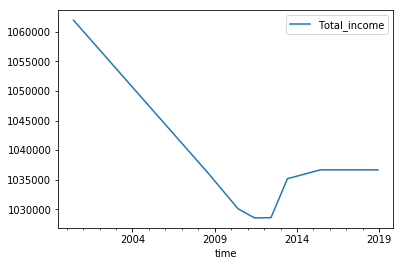

In [33]:
rob_paral_interp.set_index(['neighborhood', 'time']).groupby('time')[['Total_income']].sum().plot()

plt.show()

In [34]:
total_data_by_area = rob_paral_interp.groupby(['neighborhood', 'time'])['Total_demographic'].sum().reset_index()\
    .pivot(index = 'time', columns = 'neighborhood', values = 'Total_demographic')

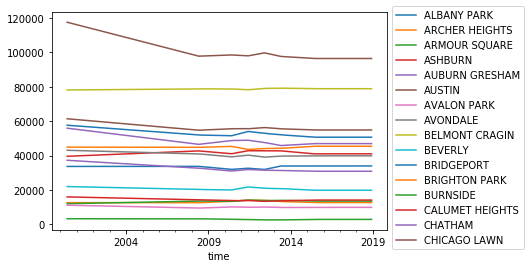

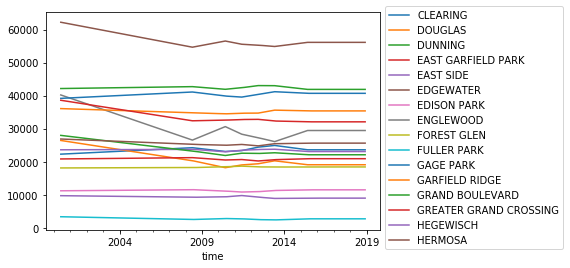

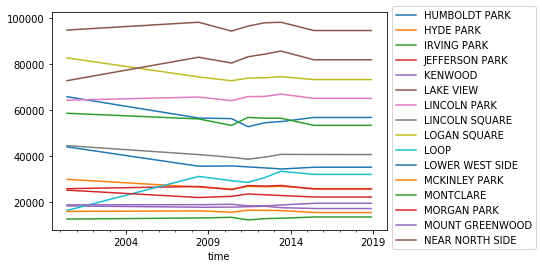

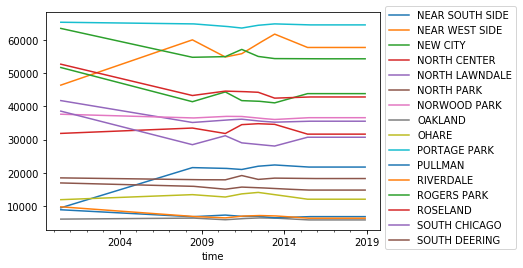

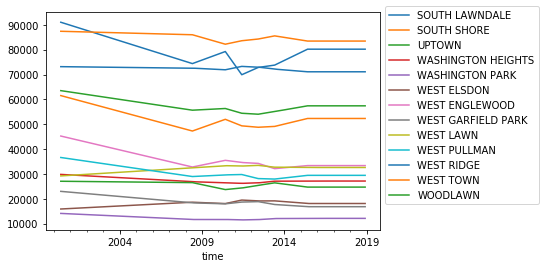

In [35]:
multi_timeseries_explore_plot(total_data_by_area)

plt.show()

In [36]:
total_data_by_area = rob_paral_interp.groupby(['neighborhood', 'time'])['$25,000 to $29,999'].sum().reset_index()\
    .pivot(index = 'time', columns = 'neighborhood', values = '$25,000 to $29,999')

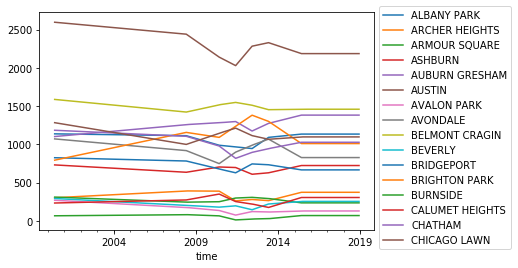

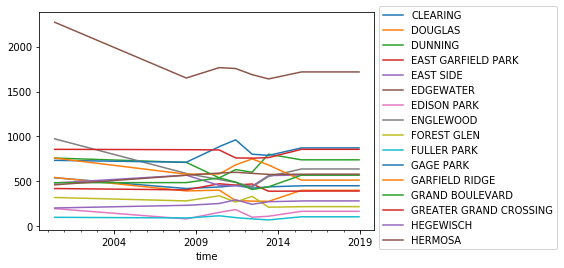

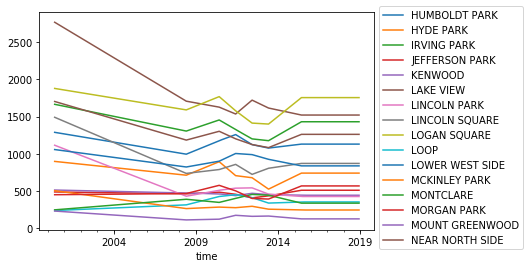

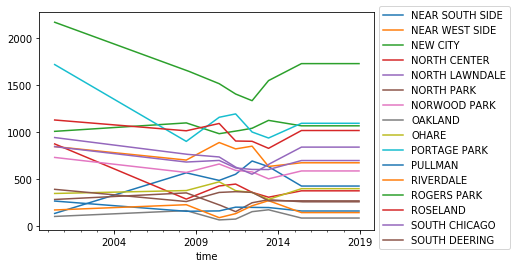

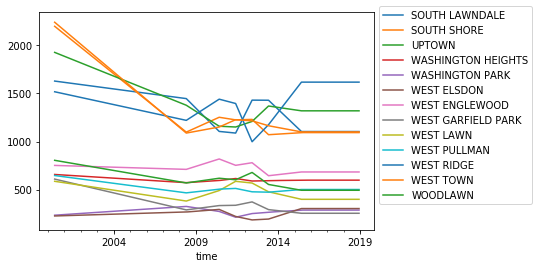

In [37]:
multi_timeseries_explore_plot(total_data_by_area)

plt.show()

## Sandbox

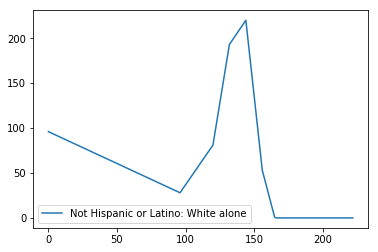

In [38]:
rob_paral_interp[rob_paral_interp['neighborhood'] == 'AVALON PARK'][['Not Hispanic or Latino: White alone']].plot()

In [39]:
total_data_by_area.tail()

neighborhood,ALBANY PARK,ARCHER HEIGHTS,ARMOUR SQUARE,ASHBURN,AUBURN GRESHAM,AUSTIN,AVALON PARK,AVONDALE,BELMONT CRAGIN,BEVERLY,...,WASHINGTON HEIGHTS,WASHINGTON PARK,WEST ELSDON,WEST ENGLEWOOD,WEST GARFIELD PARK,WEST LAWN,WEST PULLMAN,WEST RIDGE,WEST TOWN,WOODLAWN
time,,,,,,,,,,,,,,,,,,,,,
2018-08,1136.0,375.0,237.0,725.0,1384.0,2188.0,131.0,829.0,1461.0,256.0,...,600.0,289.0,305.0,685.0,256.0,401.0,503.0,1618.0,1101.0,495.0
2018-09,1136.0,375.0,237.0,725.0,1384.0,2188.0,131.0,829.0,1461.0,256.0,...,600.0,289.0,305.0,685.0,256.0,401.0,503.0,1618.0,1101.0,495.0
2018-10,1136.0,375.0,237.0,725.0,1384.0,2188.0,131.0,829.0,1461.0,256.0,...,600.0,289.0,305.0,685.0,256.0,401.0,503.0,1618.0,1101.0,495.0
2018-11,1136.0,375.0,237.0,725.0,1384.0,2188.0,131.0,829.0,1461.0,256.0,...,600.0,289.0,305.0,685.0,256.0,401.0,503.0,1618.0,1101.0,495.0
2018-12,1136.0,375.0,237.0,725.0,1384.0,2188.0,131.0,829.0,1461.0,256.0,...,600.0,289.0,305.0,685.0,256.0,401.0,503.0,1618.0,1101.0,495.0
